# ML with AMULETY embeddings

This tutorial demonstrates how to use AMULETY for downstream machine learning tasks with B-cell receptor (BCR) data. AMULETY is a python package for generating embeddings from BCR and TCR sequences using various state-of-the-art models.

## Overview

In this tutorial, you will learn to:
1. Install and set up AMULETY
2. Load and prepare BCR data in AIRR format
3. Generate embeddings using different models
4. Perform downstream machine learning tasks
5. Evaluate model performance

## Installation

First, install AMULETY using pip:

In [ ]:
# Install Amulety
!pip install amulety

# Install additional dependencies for this tutorial
# !pip install pandas numpy scikit-learn torch matplotlib seaborn

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Import Amulety
from amulety import embed_airr

print("All libraries imported successfully!")

All libraries imported successfully!


## Load BCR Data

We'll load the BCR data in AIRR (Adaptive Immune Receptor Repertoire) format. This dataset contains antibody sequences with associated metadata including gene usage, isotype, and other annotations.

In [2]:
# Download the tutorial dataset
! mkdir -p tutorial
! LC_ALL=C wget -P tutorial https://zenodo.org/records/17186858/files/ML_bcr_airr_dataset.tsv

--2025-09-24 12:52:22--  https://zenodo.org/records/17186858/files/ML_bcr_airr_dataset.tsv
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345071483 (329M) [application/octet-stream]
Saving to: 'tutorial/ML_bcr_airr_dataset.tsv'

ML_bcr_airr_dataset 100%[===================>] 329.08M  1.93MB/s    in 3m 31s  

2025-09-24 12:55:54 (1.56 MB/s) - 'tutorial/ML_bcr_airr_dataset.tsv' saved [345071483/345071483]



In [8]:
# Load the BCR AIRR dataset
bcr_data = pd.read_csv("tutorial/ML_bcr_airr_dataset.tsv", sep='\t')

print(f"Dataset shape: {bcr_data.shape}")
print(f"\nColumns: {list(bcr_data.columns)}")
print(f"\nFirst few rows:")
bcr_data.head()

Dataset shape: (1399366, 19)

Columns: ['sequence_id', 'sequence_vdj_aa', 'locus', 'cell_id', 'chain_type', 'v_call', 'v_call_family', 'j_call_family', 'mu_freq', 'junction_aa_length', 'isotype', 'source', 'subject', 'specificity', 'duplicate_count', 'productive', 'rev_comp', 'stop_codon', 'vj_in_frame']

First few rows:


,sequence_id,sequence_vdj_aa,locus,cell_id,chain_type,v_call,v_call_family,j_call_family,mu_freq,junction_aa_length,isotype,source,subject,specificity,duplicate_count,productive,rev_comp,stop_codon,vj_in_frame
0,1_heavy,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMSWIRQAPGKGLE...,IGH,cell_1,H,IGHV3-11,IGHV3,IGHJ4,0.016447,12.0,NaN,OAS,OAS_King_Subject-BCP3,unlabeled,1,True,False,False,True
1,2_heavy,QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYAMHWVRQAPGKGLE...,IGH,cell_2,H,IGHV3-30,IGHV3,IGHJ4,0.026578,17.0,NaN,OAS,OAS_King_Subject-BCP3,unlabeled,1,True,False,False,True
2,3_heavy,EVQLVESGGGLVKPGGSLTLSCAVSGFTFKNAWMSWVRQAPGKGLE...,IGH,cell_3,H,IGHV3-15,IGHV3,IGHJ4,0.069536,14.0,NaN,OAS,OAS_King_Subject-BCP3,unlabeled,1,True,False,False,True
3,4_heavy,EVQLVESGGALVKPGGSLRLSCVVSGLTFTDAYMIWVRQAPGKGLE...,IGH,cell_4,H,IGHV3-15,IGHV3,IGHJ6,0.075410,14.0,NaN,OAS,OAS_King_Subject-BCP3,unlabeled,1,True,False,False,True
4,5_heavy,QEELVEAGGTVVQPGRSLGLSCAASGFSFSNYLMHWVRQTPGKGLE...,IGH,cell_5,H,IGHV3-30-3,IGHV3,IGHJ5,0.076923,22.0,NaN,OAS,OAS_King_Subject-BCP3,unlabeled,1,True,False,False,True


## Data Exploration

Let's explore the dataset to understand its structure and characteristics.

In [9]:
# Basic statistics
print("Dataset Statistics:")
print(f"Total sequences: {len(bcr_data)}")
print(f"Unique subjects: {bcr_data['subject'].nunique()}")
print(f"Chain types: {bcr_data['chain_type'].value_counts().to_dict()}")
print(f"Locus distribution: {bcr_data['locus'].value_counts().to_dict()}")

# Check sequence length distribution
bcr_data['sequence_length'] = bcr_data['sequence_vdj_aa'].str.len()
print(f"\nSequence length statistics:")
print(bcr_data['sequence_length'].describe())

Dataset Statistics:
Total sequences: 1399366
Unique subjects: 74
Chain types: {'H': 858682, 'L': 540684}
Locus distribution: {'IGH': 858682, 'IGK': 314772, 'IGL': 225912}

Sequence length statistics:
count    1.399366e+06
mean     1.171950e+02
std      8.253170e+00
min      2.100000e+01
25%      1.100000e+02
50%      1.190000e+02
75%      1.230000e+02
max      1.860000e+02
Name: sequence_length, dtype: float64


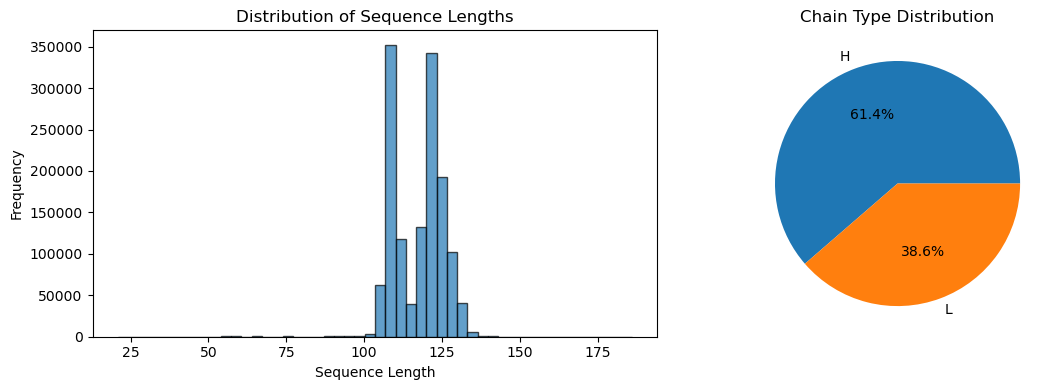

In [10]:
# Visualize sequence length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(bcr_data['sequence_length'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')

plt.subplot(1, 2, 2)
chain_counts = bcr_data['chain_type'].value_counts()
plt.pie(chain_counts.values, labels=chain_counts.index, autopct='%1.1f%%')
plt.title('Chain Type Distribution')

plt.tight_layout()
plt.show()

## Generate Embeddings with Amulety

Now we'll use Amulety to generate embeddings from our BCR sequences. Amulety supports multiple embedding models including BCR-specific models and protein language models.

In [26]:
# Prepare data for embedding
# Filter for heavy chains only for this example
heavy_chains = bcr_data[bcr_data['chain_type'] == 'H'].copy()
print(f"Using {len(heavy_chains)} heavy chain sequences for embedding")

# Take a subset for demonstration 
# please adjust size based on computational resources)
sample_size = min(10000, len(heavy_chains))
heavy_sample = heavy_chains.sample(n=sample_size, random_state=42).reset_index(drop=True)
print(f"Working with {len(heavy_sample)} sequences for demonstration")

Using 858682 heavy chain sequences for embedding
Working with 10000 sequences for demonstration


In [27]:
# Generate embeddings using antiBERTy model
print("Generating embeddings using antiBERTy model...")

# First, ensure the data has the required duplicate_count column
if 'duplicate_count' not in heavy_sample.columns:
    heavy_sample = heavy_sample.copy()
    heavy_sample['duplicate_count'] = 1
    print("Added duplicate_count column for amulety compatibility")

embeddings, filtered_data = embed_airr(
    airr=heavy_sample,
    chain="H",  # Heavy chain only
    model="antiberty",  # antiBERTy - Antibody BERT model
    sequence_col="sequence_vdj_aa",
    cell_id_col="cell_id",
    batch_size=8,  # Adjust based on available memory
    output_type="pickle"  
)

print(f"Embeddings generated successfully!")
print(f"Embedding shape: {embeddings.shape}")
print(f"Embedding dimensions: {embeddings.shape[1]}")

# Convert to numpy for downstream analysis
X_embeddings = embeddings.numpy() if hasattr(embeddings, 'numpy') else embeddings

2025-09-24 13:10:15,972 - INFO - Detected single-cell data format
2025-09-24 13:10:15,987 - INFO - Single-cell AIRR data detected (all entries have cell_id).
2025-09-24 13:10:16,117 - INFO - AntiBERTy loaded. Size: 26.03 M
2025-09-24 13:10:16,117 - INFO - Batch 1/1250


Generating embeddings using antiBERTy model...


2025-09-24 13:10:16,202 - INFO - Batch 2/1250
2025-09-24 13:10:16,265 - INFO - Batch 3/1250
2025-09-24 13:10:16,332 - INFO - Batch 4/1250
2025-09-24 13:10:16,418 - INFO - Batch 5/1250
2025-09-24 13:10:16,487 - INFO - Batch 6/1250
2025-09-24 13:10:16,541 - INFO - Batch 7/1250
2025-09-24 13:10:16,598 - INFO - Batch 8/1250
2025-09-24 13:10:16,671 - INFO - Batch 9/1250
2025-09-24 13:10:16,740 - INFO - Batch 10/1250
2025-09-24 13:10:16,805 - INFO - Batch 11/1250
2025-09-24 13:10:16,876 - INFO - Batch 12/1250
2025-09-24 13:10:16,935 - INFO - Batch 13/1250
2025-09-24 13:10:16,997 - INFO - Batch 14/1250
2025-09-24 13:10:17,056 - INFO - Batch 15/1250
2025-09-24 13:10:17,114 - INFO - Batch 16/1250
2025-09-24 13:10:17,172 - INFO - Batch 17/1250
2025-09-24 13:10:17,230 - INFO - Batch 18/1250
2025-09-24 13:10:17,287 - INFO - Batch 19/1250
2025-09-24 13:10:17,345 - INFO - Batch 20/1250
2025-09-24 13:10:17,413 - INFO - Batch 21/1250
2025-09-24 13:10:17,474 - INFO - Batch 22/1250
2025-09-24 13:10:17,5

Embeddings generated successfully!
Embedding shape: torch.Size([10000, 512])
Embedding dimensions: 512


## Prepare Data for Machine Learning

We'll prepare the data for downstream machine learning tasks. In this example, we'll predict V gene family usage from the embeddings.

In [28]:
# Prepare labels for prediction task
# Example: Predict V gene family
target_column = 'v_call_family'
y_labels = heavy_sample[target_column].values
subjects = heavy_sample['subject'].values

# Remove samples with missing labels
valid_mask = pd.notna(y_labels)
X_embeddings = X_embeddings[valid_mask]
y_labels = y_labels[valid_mask]
subjects = subjects[valid_mask]

print(f"Data after removing missing labels:")
print(f"Samples: {len(y_labels)}")
print(f"Features: {X_embeddings.shape[1]}")
print(f"Unique subjects: {len(np.unique(subjects))}")

# Check class distribution
class_counts = Counter(y_labels)
print(f"\nClass distribution:")
for class_name, count in class_counts.most_common():
    print(f"  {class_name}: {count}")

Data after removing missing labels:
Samples: 10000
Features: 512
Unique subjects: 73

Class distribution:
  IGHV3: 4755
  IGHV4: 2271
  IGHV1: 1968
  IGHV5: 450
  IGHV2: 421
  IGHV6: 87
  IGHV7: 46
  IGHV4/OR15: 1
  IGHV3/OR16: 1


In [44]:
# Filter classes with sufficient samples
MIN_CLASS_SIZE = 200  # Minimum samples per class
MAX_CLASS_SIZE = 2000  # Maximum samples per class for balanced training

# Keep only classes with sufficient samples
valid_classes = [cls for cls, count in class_counts.items() if count >= MIN_CLASS_SIZE]
valid_mask = np.isin(y_labels, valid_classes)

X_filtered = X_embeddings[valid_mask]
y_filtered = y_labels[valid_mask]
subjects_filtered = subjects[valid_mask]

print(f"After filtering classes with < {MIN_CLASS_SIZE} samples:")
print(f"Samples: {len(y_filtered)}")
print(f"Classes: {len(valid_classes)}")
print(f"Valid classes: {valid_classes}")

After filtering classes with < 200 samples:
Samples: 9865
Classes: 5
Valid classes: ['IGHV3', 'IGHV4', 'IGHV5', 'IGHV1', 'IGHV2']


In [45]:
# Subsample large classes for balanced training
def subsample_classes(X, y, subjects, max_size=MAX_CLASS_SIZE, random_state=42):
    """Subsample classes to have at most max_size samples each"""
    np.random.seed(random_state)
    
    indices_to_keep = []
    for class_name in np.unique(y):
        class_indices = np.where(y == class_name)[0]
        if len(class_indices) <= max_size:
            indices_to_keep.extend(class_indices)
        else:
            # Randomly sample max_size indices
            sampled_indices = np.random.choice(class_indices, size=max_size, replace=False)
            indices_to_keep.extend(sampled_indices)
    
    indices_to_keep = np.array(indices_to_keep)
    return X[indices_to_keep], y[indices_to_keep], subjects[indices_to_keep]

# Apply subsampling
X_final, y_final, subjects_final = subsample_classes(X_filtered, y_filtered, subjects_filtered)

print(f"Final dataset after subsampling:")
print(f"Samples: {len(y_final)}")
print(f"Features: {X_final.shape[1]}")
print(f"Classes: {len(np.unique(y_final))}")

# Final class distribution
final_class_counts = Counter(y_final)
print(f"\nFinal class distribution:")
for class_name, count in final_class_counts.most_common():
    print(f"  {class_name}: {count}")

Final dataset after subsampling:
Samples: 6839
Features: 512
Classes: 5

Final class distribution:
  IGHV3: 2000
  IGHV4: 2000
  IGHV1: 1968
  IGHV5: 450
  IGHV2: 421


## Machine Learning Pipeline

We'll implement a robust machine learning pipeline using nested cross-validation to evaluate the predictive power of our embeddings.

In [50]:
# Set up nested cross-validation
n_splits_outer = 4
n_splits_inner = 4

# Use StratifiedGroupKFold to ensure subjects don't appear in both train and test
outer_cv = StratifiedGroupKFold(n_splits=n_splits_outer, shuffle=True, random_state=42)
inner_cv = StratifiedGroupKFold(n_splits=n_splits_inner, shuffle=True, random_state=43)

# Hyperparameter grid for SVM
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100]
}

print(f"Setting up nested cross-validation:")
print(f"Outer folds: {n_splits_outer}")
print(f"Inner folds: {n_splits_inner}")
print(f"Hyperparameter grid: {param_grid}")

Setting up nested cross-validation:
Outer folds: 4
Inner folds: 4
Hyperparameter grid: {'C': [0.01, 0.1, 1, 10, 100]}


In [51]:
# Run nested cross-validation
print("Running nested cross-validation...")
print("This may take a few minutes depending on dataset size and computational resources.")

# Initialize results storage
cv_results = {
    'fold': [],
    'f1_score': [],
    'mcc_score': [],
    'accuracy': [],
    'best_C': []
}

# Perform nested cross-validation
fold_idx = 1
for train_idx, test_idx in outer_cv.split(X_final, y_final, subjects_final):
    print(f"\n--- Outer Fold {fold_idx} ---")
    
    # Split data
    X_train, X_test = X_final[train_idx], X_final[test_idx]
    y_train, y_test = y_final[train_idx], y_final[test_idx]
    subjects_train = subjects_final[train_idx]
    
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    
    # Inner cross-validation for hyperparameter tuning
    svm_model = SVC(kernel="rbf", class_weight="balanced", random_state=42)
    
    grid_search = GridSearchCV(
        estimator=svm_model,
        param_grid=param_grid,
        cv=inner_cv,
        scoring="f1_weighted",
        n_jobs=-1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train, groups=subjects_train)
    
    # Get best model and make predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average="weighted")
    mcc = matthews_corrcoef(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    # Store results
    cv_results['fold'].append(fold_idx)
    cv_results['f1_score'].append(f1)
    cv_results['mcc_score'].append(mcc)
    cv_results['accuracy'].append(acc)
    cv_results['best_C'].append(grid_search.best_params_['C'])
    
    print(f"Best C: {grid_search.best_params_['C']}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC Score: {mcc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    
    fold_idx += 1

print("\nNested cross-validation completed!")

Running nested cross-validation...
This may take a few minutes depending on dataset size and computational resources.

--- Outer Fold 1 ---
Train size: 5623, Test size: 1216
Best C: 0.1
F1 Score: 1.0000
MCC Score: 1.0000
Accuracy: 1.0000

--- Outer Fold 2 ---
Train size: 5618, Test size: 1221
Best C: 10
F1 Score: 0.9975
MCC Score: 0.9967
Accuracy: 0.9975

--- Outer Fold 3 ---
Train size: 4598, Test size: 2241
Best C: 1
F1 Score: 0.9978
MCC Score: 0.9970
Accuracy: 0.9978

--- Outer Fold 4 ---
Train size: 4678, Test size: 2161
Best C: 0.1
F1 Score: 0.9981
MCC Score: 0.9975
Accuracy: 0.9981

Nested cross-validation completed!


## Results Analysis

Let's analyze the performance of our model and visualize the results.

In [52]:
# Convert results to DataFrame
results_df = pd.DataFrame(cv_results)

# Calculate summary statistics
print("Cross-Validation Results Summary:")
print("=" * 40)

for metric in ['f1_score', 'mcc_score', 'accuracy']:
    mean_score = results_df[metric].mean()
    std_score = results_df[metric].std()
    print(f"{metric.upper()}: {mean_score:.4f} ± {std_score:.4f}")

print(f"\nBest hyperparameters (C values): {results_df['best_C'].tolist()}")
print(f"Most common C value: {Counter(results_df['best_C']).most_common(1)[0][0]}")

# Display detailed results
print("\nDetailed Results by Fold:")
print(results_df.round(4))

Cross-Validation Results Summary:
F1_SCORE: 0.9984 ± 0.0011
MCC_SCORE: 0.9978 ± 0.0015
ACCURACY: 0.9984 ± 0.0011

Best hyperparameters (C values): [0.1, 10.0, 1.0, 0.1]
Most common C value: 0.1

Detailed Results by Fold:
   fold  f1_score  mcc_score  accuracy  best_C
0     1    1.0000     1.0000    1.0000     0.1
1     2    0.9975     0.9967    0.9975    10.0
2     3    0.9978     0.9970    0.9978     1.0
3     4    0.9981     0.9975    0.9981     0.1


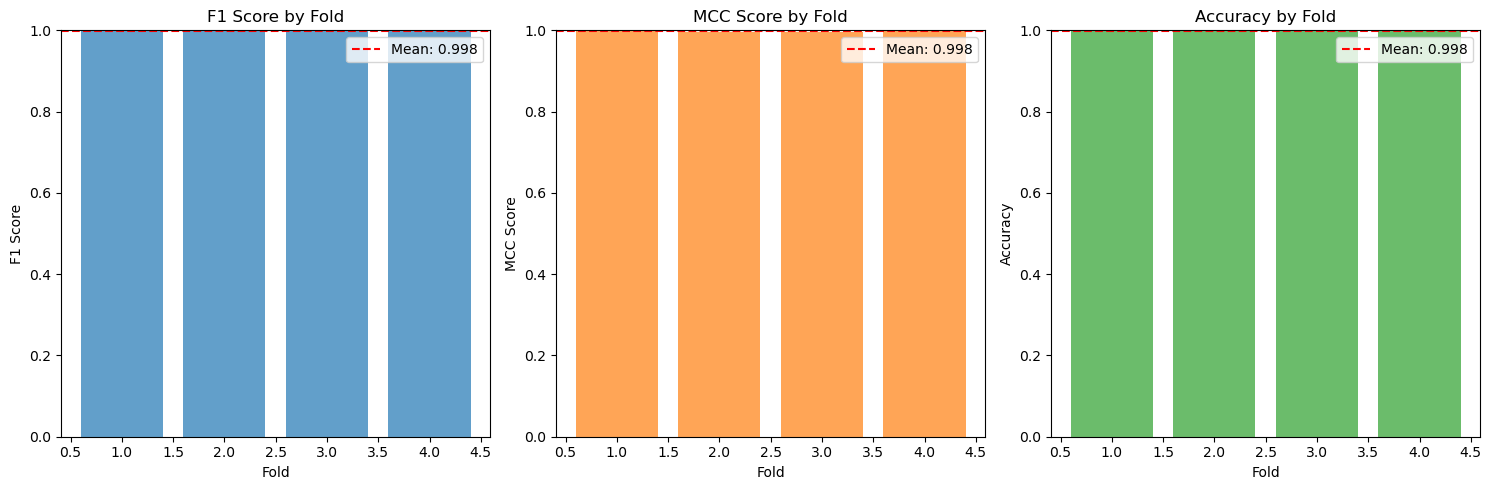

In [53]:
# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['f1_score', 'mcc_score', 'accuracy']
metric_names = ['F1 Score', 'MCC Score', 'Accuracy']

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    axes[i].bar(results_df['fold'], results_df[metric], alpha=0.7, color=f'C{i}')
    axes[i].axhline(y=results_df[metric].mean(), color='red', linestyle='--', 
                   label=f'Mean: {results_df[metric].mean():.3f}')
    axes[i].set_xlabel('Fold')
    axes[i].set_ylabel(name)
    axes[i].set_title(f'{name} by Fold')
    axes[i].legend()
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Model Comparison with Random Baseline

To validate that our embeddings contain meaningful information, let's compare against a random baseline.

In [54]:
# Create random baseline by shuffling embeddings
print("Running random baseline comparison...")

# Shuffle the embeddings while keeping labels intact
np.random.seed(42)
X_random = X_final.copy()
# Shuffle both rows and columns to completely randomize
X_random = X_random[np.random.permutation(X_random.shape[0])]
X_random = X_random[:, np.random.permutation(X_random.shape[1])]

# Run the same cross-validation with random embeddings
random_results = {
    'fold': [],
    'f1_score': [],
    'mcc_score': [],
    'accuracy': []
}

fold_idx = 1
for train_idx, test_idx in outer_cv.split(X_random, y_final, subjects_final):
    print(f"Random baseline - Fold {fold_idx}")
    
    X_train, X_test = X_random[train_idx], X_random[test_idx]
    y_train, y_test = y_final[train_idx], y_final[test_idx]
    subjects_train = subjects_final[train_idx]
    
    # Use simple SVM with default parameters for speed
    svm_model = SVC(kernel="rbf", class_weight="balanced", C=1.0, random_state=42)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average="weighted")
    mcc = matthews_corrcoef(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    random_results['fold'].append(fold_idx)
    random_results['f1_score'].append(f1)
    random_results['mcc_score'].append(mcc)
    random_results['accuracy'].append(acc)
    
    fold_idx += 1

random_df = pd.DataFrame(random_results)
print("Random baseline completed!")

Running random baseline comparison...
Random baseline - Fold 1
Random baseline - Fold 2
Random baseline - Fold 3
Random baseline - Fold 4
Random baseline completed!


In [55]:
# Compare results
print("Performance Comparison: Amulety Embeddings vs Random Baseline")
print("=" * 60)

comparison_data = []
for metric in ['f1_score', 'mcc_score', 'accuracy']:
    amulety_mean = results_df[metric].mean()
    amulety_std = results_df[metric].std()
    random_mean = random_df[metric].mean()
    random_std = random_df[metric].std()
    improvement = ((amulety_mean - random_mean) / random_mean) * 100
    
    comparison_data.append({
        'Metric': metric.upper(),
        'Amulety': f"{amulety_mean:.4f} ± {amulety_std:.4f}",
        'Random': f"{random_mean:.4f} ± {random_std:.4f}",
        'Improvement': f"{improvement:.1f}%"
    })
    
    print(f"{metric.upper()}:")
    print(f"  Amulety Embeddings: {amulety_mean:.4f} ± {amulety_std:.4f}")
    print(f"  Random Baseline:    {random_mean:.4f} ± {random_std:.4f}")
    print(f"  Improvement:        {improvement:.1f}%")
    print()

comparison_df = pd.DataFrame(comparison_data)
print("Summary Table:")
print(comparison_df.to_string(index=False))

Performance Comparison: Amulety Embeddings vs Random Baseline
F1_SCORE:
  Amulety Embeddings: 0.9984 ± 0.0011
  Random Baseline:    0.1922 ± 0.0045
  Improvement:        419.4%

MCC_SCORE:
  Amulety Embeddings: 0.9978 ± 0.0015
  Random Baseline:    -0.0032 ± 0.0069
  Improvement:        -31713.5%

ACCURACY:
  Amulety Embeddings: 0.9984 ± 0.0011
  Random Baseline:    0.1751 ± 0.0061
  Improvement:        470.2%

Summary Table:
   Metric         Amulety           Random Improvement
 F1_SCORE 0.9984 ± 0.0011  0.1922 ± 0.0045      419.4%
MCC_SCORE 0.9978 ± 0.0015 -0.0032 ± 0.0069   -31713.5%
 ACCURACY 0.9984 ± 0.0011  0.1751 ± 0.0061      470.2%


## Visualization of Results

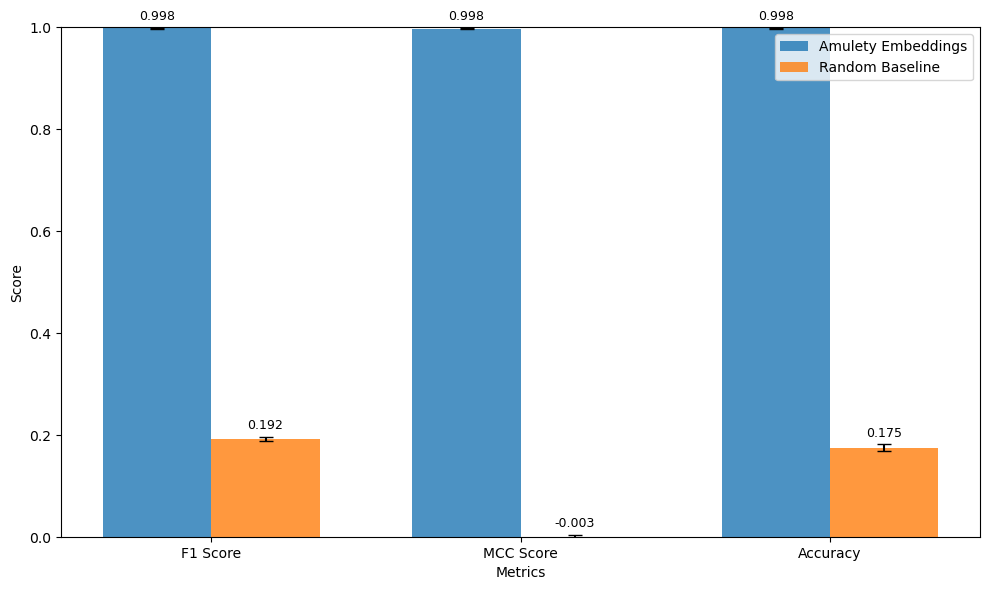

In [57]:
# Create comparison visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

metrics = ['f1_score', 'mcc_score', 'accuracy']
metric_names = ['F1 Score', 'MCC Score', 'Accuracy']

x = np.arange(len(metrics))
width = 0.35

amulety_means = [results_df[metric].mean() for metric in metrics]
amulety_stds = [results_df[metric].std() for metric in metrics]
random_means = [random_df[metric].mean() for metric in metrics]
random_stds = [random_df[metric].std() for metric in metrics]

bars1 = ax.bar(x - width/2, amulety_means, width, yerr=amulety_stds, 
               label='Amulety Embeddings', alpha=0.8, capsize=5)
bars2 = ax.bar(x + width/2, random_means, width, yerr=random_stds, 
               label='Random Baseline', alpha=0.8, capsize=5)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
# ax.set_title('Performance Comparison: Amulety Embeddings vs Random Baseline')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()
ax.set_ylim(0, 1)

# Add value labels on bars
def add_value_labels(bars, values, stds):
    for bar, val, std in zip(bars, values, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

add_value_labels(bars1, amulety_means, amulety_stds)
add_value_labels(bars2, random_means, random_stds)

plt.tight_layout()
plt.show()

In [ ]:
# Save results for future reference
results_df.to_csv('ml_cv_results.csv', index=False)
random_df.to_csv('random_baseline_results.csv', index=False)
comparison_df.to_csv('performance_comparison.csv', index=False)